In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn
import mnist_models

def transform(img):
    u = 33.3
    s = 76.8

    img = np.array(img, dtype=np.float32)
    img = (img-u)/s
    return torch.from_numpy(img)

def get_dataset(root, n):

    ds_train = torchvision.datasets.MNIST(root, train=True, transform=transform, download=False)
    ds_valid = torchvision.datasets.MNIST(root, train=False, transform=transform, download=False)

    indices = random.sample(range(len(ds_train)), n)

    # Extract random subset for training data
    ds_train.data = ds_train.data[indices]
    ds_train.targets = ds_train.targets[indices]

    return ds_train, ds_valid

def weight_stats(model):
    w = model.conv.weight.detach()
    m = w.abs().mean(dim=(1,2,3))
    s = w.abs().std(dim=(1,2,3))
    max = w.abs().amax(dim=(1,2,3))
    m_n = w.mean(dim=(1,2,3))

    plt.figure(figsize=(8,4))
    plt.plot(m, label='Average abs')
    plt.plot(s, label='Std abs')
    plt.plot(max, label='Max abs')
    plt.plot(m_n, label='Average')
    plt.legend()

root = 'K:/datasets/classification'
n = 5000
random.seed(42)

ds_train, ds_valid = get_dataset(root, n)

## Train networks

In [2]:
def train(model, ds_train, lr, bs, num_epochs, alpha, device):
    ce = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=0)
    model.to(device)

    dl = torch.utils.data.DataLoader(
        ds_train,
        batch_size=bs,
        shuffle=True,
    )

    logger = {'loss_entropy':[], 'loss_aux':[], 'acc':[]}
    for epoch in range(num_epochs):
        loss_entropy_s = 0
        loss_aux_s = 0
        model.train()
        for imgs, labels in dl:
            #imgs = torch.flatten(imgs, 1)
            imgs = imgs.to(device)
            labels = labels.to(device)
            imgs = imgs[:,None]
            ret = model.forward_train(imgs)
            res = ret['out']

            optimizer.zero_grad()
            loss_entropy = ce(res, labels)

            loss_aux = ret['pooled'].abs().mean()
            #loss_aux = loss_aux = model.conv.weight.abs().mean()
            #loss_aux = 0.

            (loss_entropy+alpha*loss_aux).backward()

            optimizer.step()
            
            loss_entropy_s += loss_entropy.item()*len(imgs)
            loss_aux_s += loss_aux.item()*len(imgs)

        loss_entropy_s = loss_entropy_s/len(ds_train)
        loss_aux_s = loss_aux_s/len(ds_train)

        model.eval()
        acc = 0
        with torch.no_grad():
            for imgs, labels in dl:
                imgs = imgs.to(device)
                labels = labels.to(device)
                #imgs = torch.flatten(imgs, 1)
                imgs = imgs[:,None]
                res = model(imgs)    
                preds = res.argmax(dim=1)
                acc += (preds==labels).sum().item()

        avg_acc = acc/len(ds_train)   

        logger['loss_entropy'].append(loss_entropy_s)
        logger['loss_aux'].append(loss_aux_s)
        logger['acc'].append(avg_acc)
        print(epoch, loss_entropy_s, loss_aux_s, 100*avg_acc)

    model.to('cpu')

    return logger

lr = 0.04
bs = 16
num_epochs = 10
alpha = 1.

models = []
for i in range(1):
    model = mnist_models.CNN()
    logger = train(model, ds_train, lr, bs, num_epochs, alpha=alpha, device='cuda')
    logger = train(model, ds_train, lr=0.01, bs=bs, num_epochs=20, alpha=alpha, device='cuda') 
    models.append(model)

0 1.9053390935897827 0.2557878871321678 48.559999999999995
1 0.7662011308193207 0.5369136445045471 87.56
2 0.5196883575439453 0.5312555148124695 86.16
3 0.44479199924468993 0.5168594622611999 89.72
4 0.43205523896217346 0.5204055346012115 85.9
5 0.3846267322063446 0.5153249940872192 89.48
6 0.3624882185399532 0.5184755019187928 92.96
7 0.3636825906038284 0.5229792468070984 89.66
8 0.36344903831481934 0.5212116452693939 79.10000000000001
9 0.37163920884132384 0.5374584552764893 82.67999999999999
0 0.23491791219711303 0.4554387264251709 94.98
1 0.23097877272367479 0.42231147594451907 95.24000000000001
2 0.23545522065162658 0.40374149265289305 95.42
3 0.2371124237537384 0.3934340567111969 95.14
4 0.23655933882594107 0.38544545254707335 95.78
5 0.23823703486919404 0.37881501865386963 93.58
6 0.23915658357143402 0.37352609605789183 95.72
7 0.2333991843700409 0.3714259726524353 94.26
8 0.23476903117895126 0.36741826791763305 95.64
9 0.23374488139152527 0.3652944729804993 95.82000000000001
10

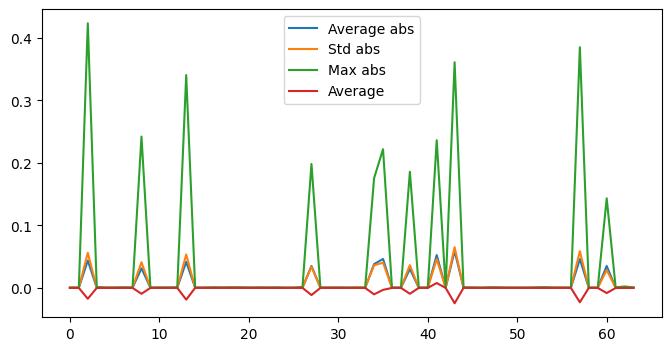

In [3]:
for model in models:
    weight_stats(model)

In [4]:
for model in models:
    print((model.conv.weight.detach().abs().amax(dim=(1,2,3))>0.02).sum())


tensor(11)


In [5]:
torch.save(model.state_dict(), 'models/cnn_sparse.pt')

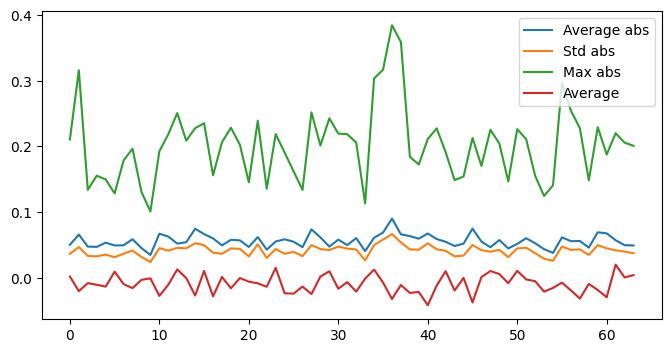

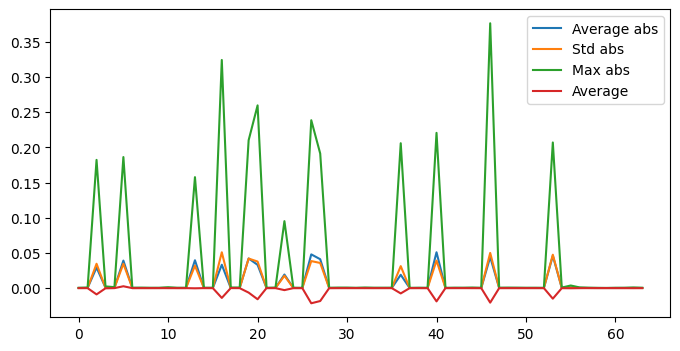

In [21]:
model1 = CNN()
model1.load_state_dict(torch.load('models/cnn.pt'))
model2 = CNN2()
model2.load_state_dict(torch.load('models/cnn_sparse.pt'))

def weight_stats(model):
    w = model.conv.weight.detach()
    m = w.abs().mean(dim=(1,2,3))
    s = w.abs().std(dim=(1,2,3))
    max = w.abs().amax(dim=(1,2,3))
    m_n = w.mean(dim=(1,2,3))

    plt.figure(figsize=(8,4))
    plt.plot(m, label='Average abs')
    plt.plot(s, label='Std abs')
    plt.plot(max, label='Max abs')
    plt.plot(m_n, label='Average')
    plt.legend()

weight_stats(model1)
weight_stats(model2)